[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
<ipython-input-3-2e70aa1926f3>:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=freq_df.head(50), palette='viridis')


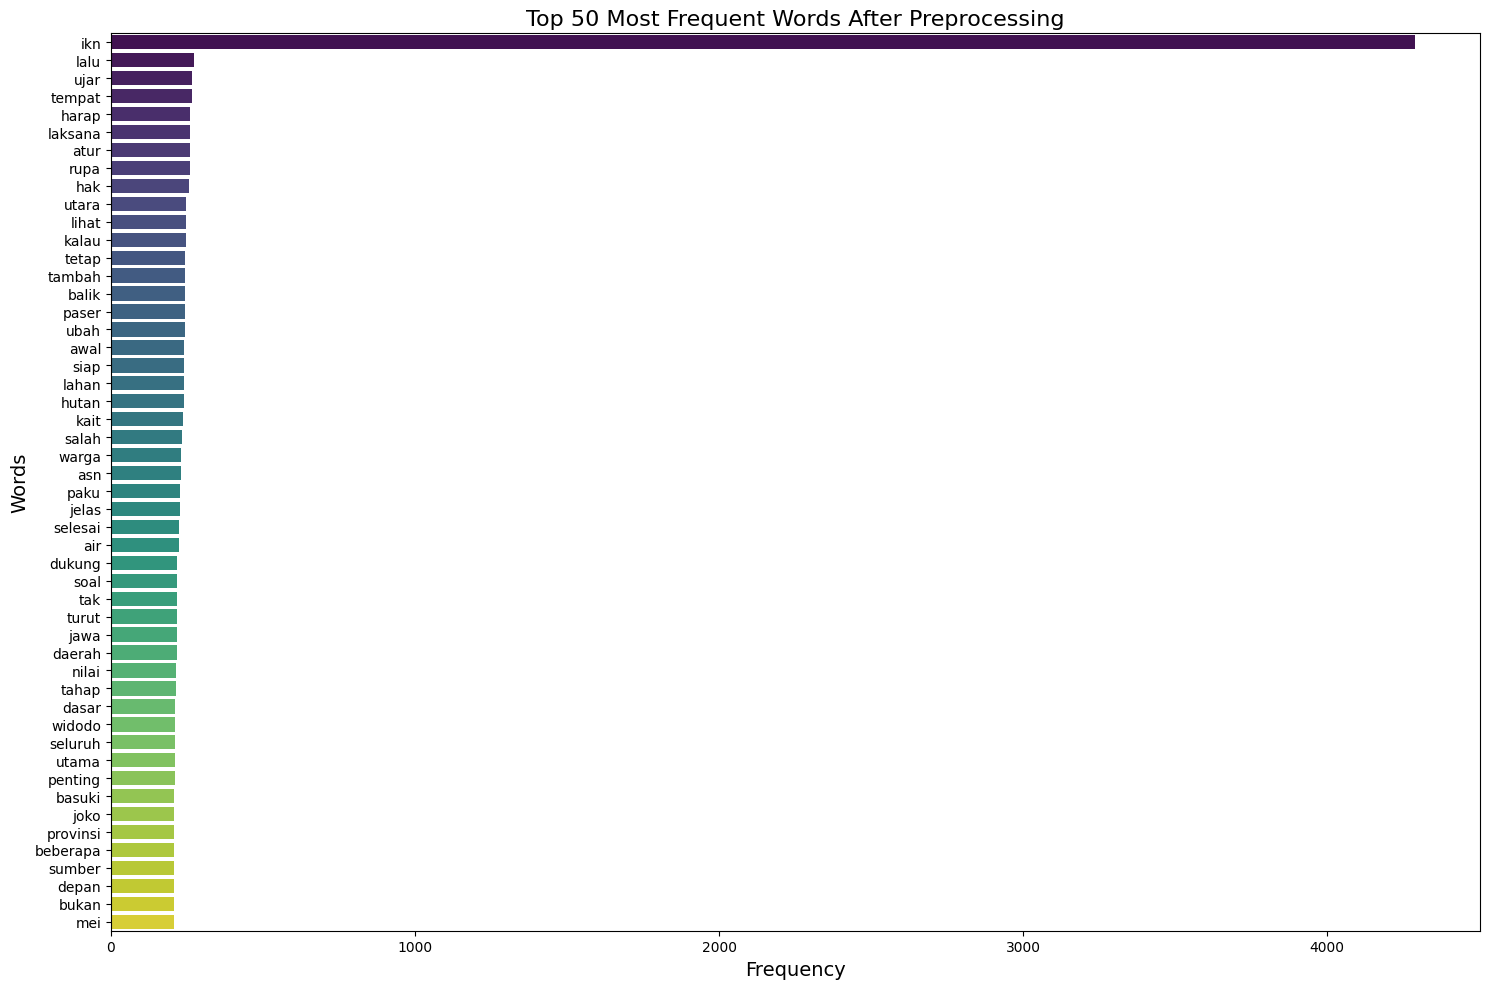

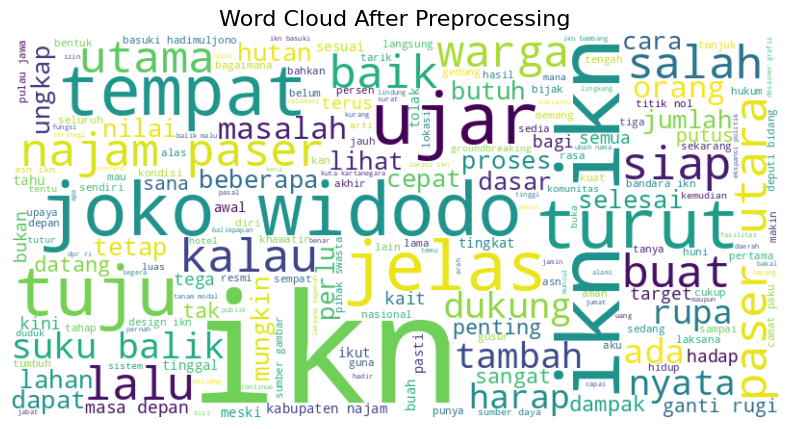

<ipython-input-3-2e70aa1926f3>:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


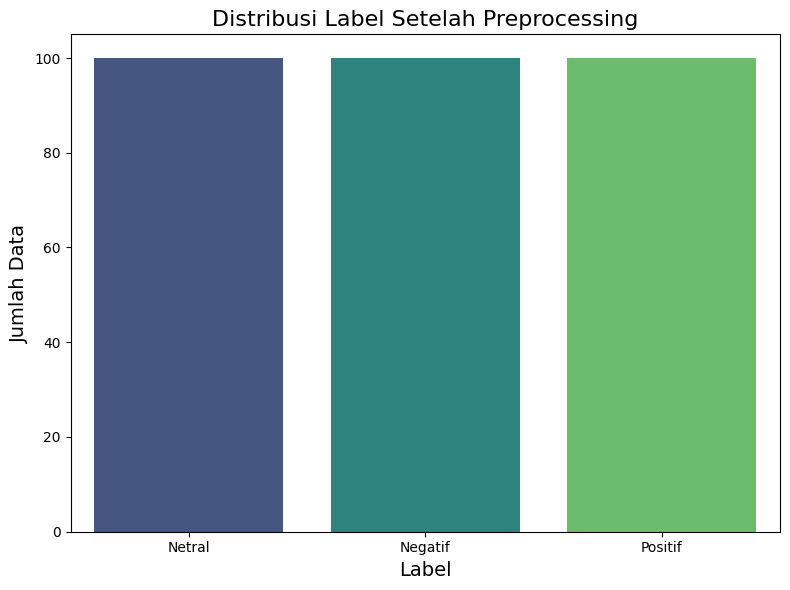

In [ ]:
# Install required packages
!pip uninstall nltk -y -q
!pip install pandas numpy nltk Sastrawi wordcloud seaborn matplotlib -q

import pandas as pd
import numpy as np
import re
import logging
from nltk.tokenize import word_tokenize
import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Clear NLTK data and reinstall
import shutil
import os
for path in nltk.data.path:
    if os.path.exists(path):
        shutil.rmtree(path, ignore_errors=True)

# Unduh data NLTK yang diperlukan
nltk.download('punkt')
nltk.download('punkt_tab')

# Inisialisasi logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load data augmentasi
try:
    df = pd.read_csv('ikn_news_augmented_full_pipeline.csv')
    logger.info("Berhasil memuat file ikn_news_augmented_full_pipeline.csv")
except FileNotFoundError:
    logger.error("File ikn_news_augmented_full_pipeline.csv tidak ditemukan.")
    raise

# Validasi kolom
required_columns = ['judul', 'cleaned_content', 'label', 'is_augmented']
if not all(col in df.columns for col in required_columns):
    missing_cols = [col for col in required_columns if col not in df.columns]
    logger.error(f"Kolom yang hilang: {missing_cols}")
    raise ValueError(f"DataFrame tidak memiliki kolom yang diperlukan: {missing_cols}")

# 1. Normalisasi Teks
def normalize_text(text):
    try:
        if not isinstance(text, str):
            return ''
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    except Exception as e:
        logger.error(f"Error in normalize_text: {e}")
        return text

df['normalized_content'] = df['cleaned_content'].apply(normalize_text)
logger.info("Normalisasi teks selesai.")

# 2. Tokenisasi
df['tokens'] = df['normalized_content'].apply(word_tokenize)
df['word_count'] = df['tokens'].apply(len)
logger.info("Tokenisasi dan perhitungan jumlah kata selesai.")

# 3. Stopwords Removal
stopword_factory = StopWordRemoverFactory()
stopwords_id = stopword_factory.get_stop_words()

custom_stopwords = [
    'yang', 'dan', 'di', 'dengan', 'untuk', 'pada', 'ini', 'dari', 'ke', 'dalam',
    'tersebut', 'adalah', 'oleh', 'sebagai', 'akan', 'telah', 'juga', 'serta', 'atau',
    'baca', 'klik', 'berita', 'oikn', 'brwa', 'the', 'isra', 'mikraj', 'rozaq', 'qosdy',
    'anggi', 'welem', 'of', 'ustadz', 'abdul', 'darmawi', 'sri', 'elisnawati', 'nurmis',
    'syarariyah', 'musmulyadi', 'to', 'scroll', 'jika', 'lebih', 'sampai', 'setelah',
    'sebelum', 'antara', 'selama', 'terhadap', 'melalui', 'hingga', 'sekitar', 'sejak'
]
stopwords_id.extend(custom_stopwords)
stopwords_id = list(set(stopwords_id))
logger.info(f"Total {len(stopwords_id)} stopwords digunakan (kecuali 'ikn').")

def remove_stopwords(text, stopwords_list):
    try:
        if not text:
            return ''
        words = text.split()
        filtered_words = [word for word in words if word not in stopwords_list or word == 'ikn']
        return ' '.join(filtered_words)
    except Exception as e:
        logger.error(f"Error in remove_stopwords: {e}")
        return text

df['content_without_stopwords'] = df['normalized_content'].apply(lambda x: remove_stopwords(x, stopwords_id))
df['word_count_no_stopwords'] = df['content_without_stopwords'].apply(lambda x: len(x.split()))
logger.info("Penghapusan stopwords selesai.")

# Lanjutkan dengan langkah-langkah lainnya seperti stemming, dll.
# (Bagian kode selanjutnya tetap sama seperti sebelumnya)

# 4. Stemming
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

stem_cache = {}

def stem_text(text):
    try:
        if not text:
            return ''
        if text in stem_cache:
            return stem_cache[text]
        words = text.split()
        stemmed_words = [word if word == 'ikn' else stemmer.stem(word) for word in words]
        stemmed_text = ' '.join(stemmed_words)
        stem_cache[text] = stemmed_text
        return stemmed_text
    except Exception as e:
        logger.error(f"Error in stem_text: {e}")
        return text

df['content_stemmed'] = df['content_without_stopwords'].apply(stem_text)
df['word_count_stemmed'] = df['content_stemmed'].apply(lambda x: len(x.split()))
logger.info("Stemming selesai (kecuali 'ikn').")

# 5. Rare and Common Words Removal
def get_word_frequencies(text_series):
    all_words = ' '.join(text_series).split()
    return Counter(all_words)

word_frequencies = get_word_frequencies(df['content_stemmed'])

freq_values = list(word_frequencies.values())
rare_threshold = 2  # Kata muncul < 2 kali
common_threshold = int(np.percentile(freq_values, 99))  # Persentil 99
logger.info(f"Rare threshold: {rare_threshold}, Common threshold: {common_threshold}")

def remove_rare_common_words(text, word_freq, rare_thresh, common_thresh):
    if not text:
        return ''
    words = text.split()
    filtered_words = [
        word for word in words
        if (rare_thresh <= word_freq.get(word, 0) <= common_thresh) or word == 'ikn'
    ]
    return ' '.join(filtered_words)

df['filtered_content'] = df['content_stemmed'].apply(
    lambda x: remove_rare_common_words(x, word_frequencies, rare_threshold, common_threshold)
)
df['word_count_filtered'] = df['filtered_content'].apply(lambda x: len(x.split()))
logger.info("Penghapusan rare/common words selesai (kecuali 'ikn').")

# 6. Validasi Hasil
empty_texts = df[df['filtered_content'].str.strip() == '']
if not empty_texts.empty:
    logger.warning(f"Terdapat {len(empty_texts)} teks kosong setelah preprocessing.")
    df.loc[df['filtered_content'].str.strip() == '', 'filtered_content'] = df['normalized_content']

# 7. Analisis Frekuensi Kata dan Visualisasi
freq_df = get_word_frequencies(df['filtered_content'])
freq_df = pd.DataFrame(freq_df.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

# Plot Top 50 Kata
plt.figure(figsize=(15, 10))
sns.barplot(x='count', y='word', data=freq_df.head(50), palette='viridis')
plt.title('Top 50 Most Frequent Words After Preprocessing', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.tight_layout()
plt.savefig('top_50_words.png')
plt.show()

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(
    ' '.join(df['filtered_content'])
)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud After Preprocessing', fontsize=16)
plt.savefig('wordcloud_filtered.png')
plt.show()

# Distribusi Label
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribusi Label Setelah Preprocessing', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Jumlah Data', fontsize=14)
plt.tight_layout()
plt.savefig('label_distribution.png')
plt.show()

# 8. Simpan Hasil
output_file_csv = 'ikn_news_preprocessed_final.csv'
output_file_excel = 'ikn_news_preprocessed_final.xlsx'
df.to_csv(output_file_csv, index=False)
df.to_excel(output_file_excel, index=False)
logger.info(f"DataFrame disimpan ke {output_file_csv} dan {output_file_excel}")

# Ringkasan
logger.info(f"Total data: {len(df)}")
logger.info(f"Distribusi label:\n{df['label'].value_counts().to_string()}")
logger.info(f"Top 10 kata:\n{freq_df.head(10).to_string()}")
logger.info(df[['judul', 'filtered_content', 'label', 'is_augmented']].head().to_string())